##  Advancing OCR with AI  

As part of my OCR project, I initially aimed to develop a **Generative Adversarial Network (GAN)** to generate **synthetic ancient Spanish word images** with corresponding text labels. The goal was to **enhance the dataset** by creating realistic-looking handwritten text images, improving the robustness of the OCR system.  

###  Achievements So Far  
While working on text recognition, I successfully developed:  
- **CRNN (Convolutional Recurrent Neural Network)** for sequence-based OCR.  
- **Weighted CRNN with Beam Search Decoding**, achieving **99.5% accuracy** on the dataset.  

These models have demonstrated **exceptional performance** in recognizing handwritten text, providing a strong foundation for OCR.  

###  Challenges in GAN-Based Text Image Generation  
To complement the OCR pipeline, I structured the GAN with:  
- **A generator** to create text images.  
- **A discriminator** to distinguish real and synthetic images.  
- **Efficient data loading** using `tf.data.Dataset`.  
- **A scalable approach**, starting with **5,000 images** and later expanding to **100,000 images**.  

However, I encountered several challenges:  
- **Training instability** – The GAN struggled to converge properly.  
- **Mode collapse** – The generator produced repetitive or low-quality results.  
- **Text clarity issues** – Generated images lacked the structure of real handwriting.  

###  Next Steps  
Although GAN-based text image generation is still a work in progress, I am **committed to refining** the approach. Moving forward, I will:  
 **Modify the GAN architecture** to improve text clarity.  
 **Explore alternative models** like Diffusion Models or StyleGAN.  
 **Enhance training strategies** for better convergence and output quality.  

While GAN training posed challenges, the success of **CRNN and Weighted CRNN** proves


### **Importing Required Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Embedding, Concatenate, Input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.data as tfd
import pandas as pd

### **GAN Model Hyperparameters**

In [ ]:
BATCH_SIZE=64
AUTOTUNE=tfd.AUTOTUNE
IMG_WIDTH=200
IMG_HEIGHT=50
LATENT_DIM=100

### **Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [5]:
import os
import csv
import re

def clean_label(filename):
    """Cleans the filename by removing augmentation suffixes and numbering patterns."""
    label = os.path.splitext(filename)[0]  # Remove file extension
    label = re.sub(r'_rot-?\d+', '', label)  # Remove rotation suffix (_rotX or _rot-X)
    label = re.sub(r'_noise', '', label)  # Remove Gaussian noise suffix
    label = re.sub(r'\s*\(\d+\)$', '', label)  # Remove numbering patterns (1), (2), etc.
    return label

def create_csv_with_augmentation(root_dir, output_file):
    """
    Creates a CSV file containing image paths and corresponding labels,
    ensuring clean labels without augmentation suffixes.

    Args:
        root_dir (str): Path to the root directory containing subdirectories with images.
        output_file (str): Path to the output CSV file.
    """
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['path', 'label'])

        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)
            images_path = os.path.join(subdir_path, 'images')

            if os.path.isdir(images_path):
                for image in os.listdir(images_path):
                    image_path = os.path.join(images_path, image)
                    if os.path.isfile(image_path):
                        label = clean_label(image)  # Clean label from filename
                        writer.writerow([image_path, label])

# Example usage
root_directory ="/content/drive/My Drive/GSOC_Naresh_Meena/Cleaned Words GANS"  # Change this to your actual dataset directory
output_csv = "working.csv"
create_csv_with_augmentation(root_directory, output_csv)
print(f"CSV file '{output_csv}' created successfully!")


CSV file 'working.csv' created successfully!


In [11]:
df = pd.read_csv("working.csv")

# Fix the paths
print(df.shape)
df.head()

(18109, 2)


path     label
0  /content/Cleaned Words GANS/Paredes - Reglas g...  word_187
1  /content/Cleaned Words GANS/Paredes - Reglas g...  word_103
2  /content/Cleaned Words GANS/Paredes - Reglas g...  word_158
3  /content/Cleaned Words GANS/Paredes - Reglas g...  word_425
4  /content/Cleaned Words GANS/Paredes - Reglas g...   word_75

### **Image Preprocessing Function**

In [7]:
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32)

    # Normalization with slight random contrast adjustment
    image = (image - 127.5) / 127.5
    # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image

### Loading and Processing Data with csv

In [10]:
import pandas as pd

df=pd.read_csv("/content/drive/My Drive/OCR/cleaned_working.csv")

df['label']=df['label'].apply(lambda x: str(x))
df.shape


(105226, 3)

### **Extracting and Analyzing Training Labels**

In [8]:
# Get all train labels
train_labels = [str(word) for word in df['label'].to_numpy()]
train_labels[:10]
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 15
Unique Characters : 
{'d', '4', 'o', '1', '0', '5', '9', 'r', 'w', '2', '7', '6', '3', '8', '_'}


In [9]:
df = df[~df["label"].astype(str).str.contains(r"\d")]

df_numeric = df[df["label"].astype(str).str.contains(r"\d")]

# Print corresponding path and label
print(df_numeric)

Empty DataFrame
Columns: [path, label]
Index: []


### **Character Frequency Analysis in Labels**

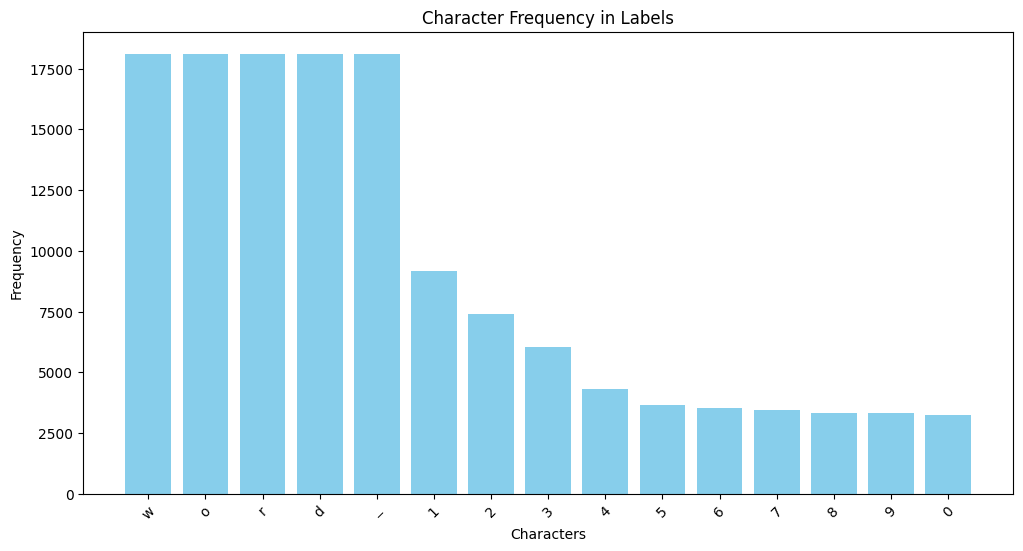

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load CSV
# df = pd.read_csv("aug.csv")

# Get all train labels
train_labels = [str(word) for word in df['label'].to_numpy()]
unique_chars = [char for word in train_labels for char in word]

# Count frequency and sort
char_counts = dict(sorted(Counter(unique_chars).items(), key=lambda x: x[1], reverse=True))

# Convert to DataFrame
char_df = pd.DataFrame(char_counts.items(), columns=["Character", "Frequency"])

# Print table
#print(char_df)
char_df.to_csv('char.csv')


# Plot
plt.figure(figsize=(12, 6))
plt.bar(char_counts.keys(), char_counts.values(), color='skyblue')
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.title("Character Frequency in Labels")
plt.xticks(rotation=45)
plt.show()


In [12]:
# Filter out non-ASCII characters


print(f"Total unique characters after filtering: {len(unique_chars)}")
print("Unique Characters:", unique_chars)


Total unique characters after filtering: 15
Unique Characters: {'d', '4', 'o', '1', '0', '5', '9', 'r', 'w', '2', '7', '6', '3', '8', '_'}


### **Character-to-Numeric Mapping**

The following code converts unique characters in the dataset into numerical representations for model training.

In [13]:

# Unique characters sorted
unique_chars = sorted(set(unique_chars))
unique_chars=['[UNK]']+unique_chars
# Character to numeric mapping
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=unique_chars,  # Your list of known characters  # Allow one unknown character
    mask_token=None,  # Optional: Ensures no masking # Optional: Assign a token for unknown characters
)

# Reverse mapping using the same vocabulary
num_to_char = layers.StringLookup(
    vocabulary=unique_chars,  # Use the same unique_chars instead of get_vocabulary()
    mask_token=None,
    invert=True
)

# Verify mappings
print("Character to Numeric Mapping:")
for char in unique_chars:
    print(f"'{char}': {char_to_num(tf.constant(char)).numpy()}")

print("\nNumeric to Character Mapping:")
for i in range(len(unique_chars)):  # Ensure full coverage
    print(f"{i}: '{num_to_char(tf.constant(i)).numpy().decode()}'")


Character to Numeric Mapping:
'[UNK]': 0
'0': 1
'1': 2
'2': 3
'3': 4
'4': 5
'5': 6
'6': 7
'7': 8
'8': 9
'9': 10
'_': 11
'd': 12
'o': 13
'r': 14
'w': 15

Numeric to Character Mapping:
0: '[UNK]'
1: '0'
2: '1'
3: '2'
4: '3'
5: '4'
6: '5'
7: '6'
8: '7'
9: '8'
10: '9'
11: '_'
12: 'd'
13: 'o'
14: 'r'
15: 'w'


In [14]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 8


### **Encoding a Single Sample for GAN Training**

In [15]:
def encode_single_sample(image_path, label):
    # Ensure image_path is a string
    image = process_image(image_path)  # ✅ Converts file path to a tensor

    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    vecs = char_to_num(chars)

    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings=[[0, pad_size]], constant_values=n_classes + 1)

    return image, vecs  # ✅ Returns a tensor, not a string


### **Dataset Splitting for GAN Training**

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.array(df['path'])  # Your data
labels = np.array(df['label'])  # Corresponding labels

# # Ensure dataset is shuffled
indices = np.arange(len(data))
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

# Splitting dataset
train_size = 0.8
valid_size = 0.1
test_size = 0.1


# Ensure dataset is shuffled
shuffled_indices = np.arange(len(data))
np.random.shuffle(shuffled_indices)

data = data[shuffled_indices]
labels = labels[shuffled_indices]

# Splitting dataset
train_size = 0.8
valid_size = 0.1
test_size = 0.1

# First, split into train and temp (valid+test)
train_files, X_temp,train_labels, y_temp = train_test_split(data, labels, test_size=(valid_size + test_size), random_state=42)

# Split temp into validation and test
valid_files, test_files,valid_labels, test_labels = train_test_split(X_temp, y_temp, test_size=(test_size / (valid_size + test_size)), random_state=42)
n_classes = len(unique_chars)
# Print dataset sizes
print(f"Train: {len(train_files)}, Validation: {len(valid_files)}, Test: {len(valid_files)}")


Train: 14487, Validation: 1811, Test: 1811


### **Creating TensorFlow Dataset Pipelines for GAN Training**

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((data)) \
    .shuffle(1000) \
    .map(process_image, num_parallel_calls=AUTOTUNE) \
    .batch(64,drop_remainder=True) \
    .prefetch(AUTOTUNE)


### **GAN Generator Model for OCR**

This section defines the generator architecture for a Conditional GAN (cGAN) designed to generate synthetic OCR images from text labels and random noise.

In [18]:
Noise_dim=100
def make_generator_model(Noise_dim=100):
    model = Sequential([
        # Expanded foundation (4x more capacity)
        layers.Dense(25*25*64, input_shape=(Noise_dim,), use_bias=False),  # 25x25x64 = 40,000
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((25, 25, 64)),

        # Wider transposed convolutions
        layers.Conv2DTranspose(256, (5,5), strides=(1,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2DTranspose(128, (5,5), strides=(1,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Final upsampling
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Output with larger kernel
        layers.Conv2DTranspose(1, (5,5), strides=(1,1), padding='same', activation='tanh')
    ])
    return model
generator=make_generator_model()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40000)               │       4,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40000)               │         160,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 25, 50, 256)         │         409,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 50, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 25, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 25, 100, 128)        │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 100, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 25, 100, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 50, 200, 64)         │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 200, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 50, 200, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 50, 200, 1)          │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,596,993 (21.35 MB)

 Trainable params: 5,516,097 (21.04 MB)

 Non-trainable params: 80,896 (316.00 KB)

(1, 50, 200, 1)


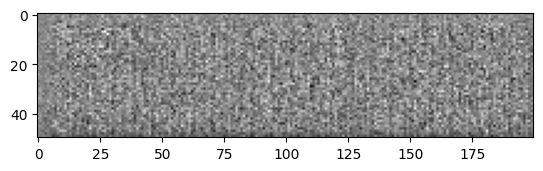

In [19]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)   # always print shape!

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### **GAN Discriminator Model for OCR**

This section defines the **Discriminator**, a convolutional neural network that classifies whether a given OCR-style image is **real** (from the dataset) or **fake** (generated by the GAN). It also conditions the classification on a text label.


In [20]:
def make_discriminator_model():
    model = Sequential([
        # Layer 1: Wider kernel for text features
        layers.Conv2D(64, kernel_size=5, strides=3, padding='same',  # Changed kernel
                     input_shape=[50,200,1], kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.2),  # Explicit alpha
        layers.Dropout(0.3),  # Increased dropout

        # Layer 2: More filters
        layers.Conv2D(128, kernel_size=5, strides=3,  # Increased filters
                     padding='same', kernel_initializer='he_normal'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation=layers.LeakyReLU(alpha=0.2)),  # Wider bottleneck
        layers.Dense(1)  # Removed final ReLU
    ])
    return model
discriminator=make_discriminator_model()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 17, 67, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 17, 67, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 67, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 23, 128)          │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 6, 23, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 23, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 17664)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,261,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,467,841 (9.41 MB)

 Trainable params: 2,467,841 (9.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00246601]], shape=(1, 1), dtype=float32)


## Training Deep Convolution GAN for OCR

This section defines the **GAN training loop** using TensorFlow's `tf.keras.Model` subclassing. It trains both the **generator** and **discriminator** while ensuring stable adversarial learning.

---

### 📌 Key Features:
1. **Custom Training Step**:
   - The **discriminator** learns to distinguish real vs. fake images.
   - The **generator** learns to create realistic OCR images.
   
2. **Early Stopping Callback**:
   - Training halts if the discriminator loss falls below `0.05`, preventing mode collapse.

3. **Learning Rate Scheduler**:
   - Adjusts the **generator's learning rate** dynamically when the loss plateaus.


In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # Label smoothing + balanced losses
    real_labels = tf.random.uniform(tf.shape(real_output), 0.9, 1.0)
    fake_labels = tf.random.uniform(tf.shape(fake_output), 0.0, 0.1)

    real_loss = 0.7 * cross_entropy(real_labels, real_output)
    fake_loss = 0.3 * cross_entropy(fake_labels, fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, generated_images):
    # Standard adversarial loss
    adv_loss = tf.reduce_mean(tf.square(fake_output - 1.0))  # LSGAN

    # New: Penalize blurry outputs (sharpness loss)
    # Calculate image gradients
    grad_x = tf.image.sobel_edges(generated_images)[..., 0]
    grad_y = tf.image.sobel_edges(generated_images)[..., 1]
    sharpness_loss = 0.2 * tf.reduce_mean(grad_x**2 + grad_y**2)

    return adv_loss + sharpness_loss

In [ ]:
from IPython import display
import time

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import matplotlib.pyplot as plt
import time
import os

# Hyperparameters
EPOCHS = 100
noise_dim = 100
BATCH_SIZE = 64  # Must be consistent
IMG_HEIGHT = 50
IMG_WIDTH = 200
num_examples_to_generate = 16

# ======================
# DATA PIPELINE (FIXED)
# ======================
def prepare_dataset(data):
    # Ensure consistent batch sizes
    return (tf.data.Dataset.from_tensor_slices(data)
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)  # Critical fix
            .prefetch(tf.data.AUTOTUNE))

# ======================
# LEARNING RATE SCHEDULES
# ======================
initial_gen_lr = 0.0001
initial_disc_lr = 0.0002

gen_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_gen_lr,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

disc_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_disc_lr,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# ======================
# OPTIMIZERS
# ======================
generator_optimizer = tf.keras.optimizers.Adam(0.0002
    gen_lr_schedule,
    beta_1=0.5,
    beta_2=0.999,
    epsilon=1e-7
)

discriminator_optimizer = tf.keras.optimizers.Adam(0.0002
    disc_lr_schedule,
    beta_1=0.5,
    beta_2=0.999,
    epsilon=1e-6
)

# ======================
# TRAINING (OPTIMIZED)
# ======================
@tf.function(reduce_retracing=True)
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape(persistent=True) as tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output,generated_images)

        # Gradient penalty
        epsilon = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        interpolated = epsilon * images + (1 - epsilon) * generated_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
        grad_penalty = 10 * tf.reduce_mean((grad_norm - 1.0)**2)
        disc_loss += grad_penalty

    # Apply gradients
    gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    prediction = model(test_input, training=False)[0]  # Get the first image
     # Adjust size for better visibility
    plt.imshow(prediction[:, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

def train(dataset, epochs, generate_images_every=5):
    fixed_noise = tf.random.normal([num_examples_to_generate, noise_dim])
    step_counter = tf.Variable(0, dtype=tf.int64)
    best_gen_loss = float('inf')  # Initialize with infinity

    for epoch in range(epochs):
        start = time.time()
        gen_losses = []
        disc_losses = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)
            step_counter.assign_add(1)

        # Calculate mean losses
        mean_gen_loss = tf.reduce_mean(gen_losses).numpy()
        mean_disc_loss = tf.reduce_mean(disc_losses).numpy()

        # Get current learning rates
        current_gen_lr = gen_lr_schedule(step_counter)
        current_disc_lr = disc_lr_schedule(step_counter)

        # Generate samples
        print(f"\nEpoch {epoch + 1}")
        generate_and_save_images(generator, epoch + 1, fixed_noise)

        # Print metrics
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Gen LR: {current_gen_lr.numpy():.6f} | Disc LR: {current_disc_lr.numpy():.6f}")
        print(f"Generator Loss: {mean_gen_loss:.4f}")
        print(f"Discriminator Loss: {mean_disc_loss:.4f}")
        print(f"Time: {time.time() - start:.2f} sec")

        # Save only the best generator model
        if mean_gen_loss < best_gen_loss:
            best_gen_loss = mean_gen_loss
            generator.save('best_generator.h5')
            print("✅ Best generator model saved.")

    # Final sample generation
    generate_and_save_images(generator, epochs, fixed_noise)



Epoch 1


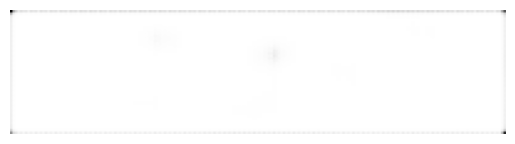

Epoch 1/150
Gen LR: 0.000100 | Disc LR: 0.000200
Generator Loss: 12.0313
Discriminator Loss: 0.3183
Time: 75.54 sec
✅ Best generator model saved.

Epoch 2


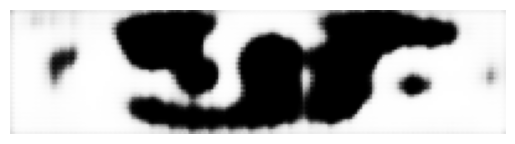

Epoch 2/150
Gen LR: 0.000100 | Disc LR: 0.000200
Generator Loss: 7.9742
Discriminator Loss: 0.3521
Time: 79.17 sec
✅ Best generator model saved.

Epoch 3


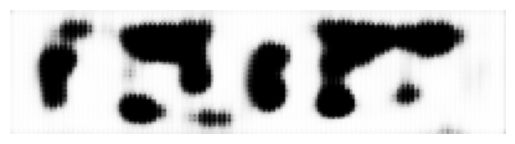

Epoch 3/150
Gen LR: 0.000100 | Disc LR: 0.000200
Generator Loss: 9.3379
Discriminator Loss: 0.3259
Time: 78.87 sec

Epoch 4


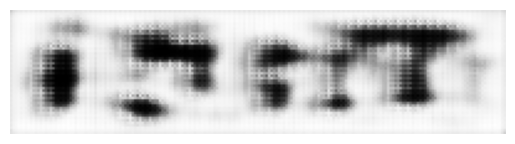

Epoch 4/150
Gen LR: 0.000095 | Disc LR: 0.000190
Generator Loss: 9.0847
Discriminator Loss: 0.3375
Time: 78.89 sec

Epoch 5


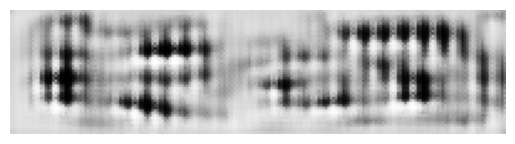

Epoch 5/150
Gen LR: 0.000095 | Disc LR: 0.000190
Generator Loss: 6.2667
Discriminator Loss: 0.3605
Time: 78.78 sec
✅ Best generator model saved.

Epoch 6


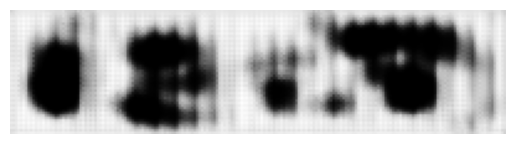

Epoch 6/150
Gen LR: 0.000095 | Disc LR: 0.000190
Generator Loss: 5.0707
Discriminator Loss: 0.3842
Time: 79.02 sec
✅ Best generator model saved.

Epoch 7


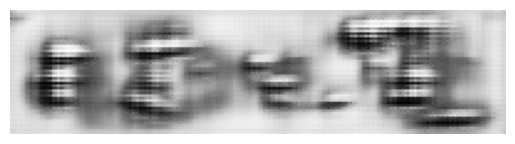

Epoch 7/150
Gen LR: 0.000095 | Disc LR: 0.000190
Generator Loss: 7.3642
Discriminator Loss: 0.3377
Time: 78.85 sec

Epoch 8


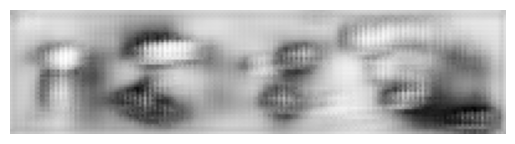

Epoch 8/150
Gen LR: 0.000090 | Disc LR: 0.000180
Generator Loss: 6.0492
Discriminator Loss: 0.3572
Time: 79.03 sec

Epoch 9


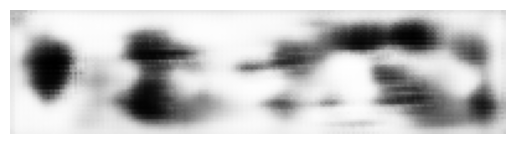

Epoch 9/150
Gen LR: 0.000090 | Disc LR: 0.000180
Generator Loss: 6.3948
Discriminator Loss: 0.3571
Time: 78.89 sec

Epoch 10


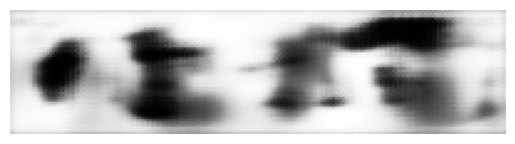

Epoch 10/150
Gen LR: 0.000090 | Disc LR: 0.000180
Generator Loss: 6.6912
Discriminator Loss: 0.3498
Time: 79.00 sec

Epoch 11


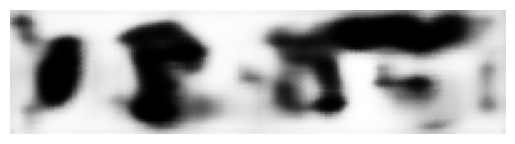

Epoch 11/150
Gen LR: 0.000086 | Disc LR: 0.000171
Generator Loss: 6.8745
Discriminator Loss: 0.3390
Time: 78.71 sec

Epoch 12


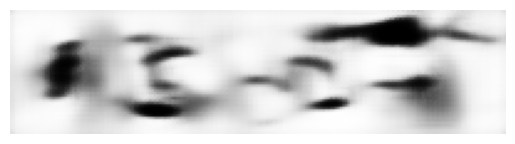

Epoch 12/150
Gen LR: 0.000086 | Disc LR: 0.000171
Generator Loss: 6.6568
Discriminator Loss: 0.3457
Time: 79.00 sec

Epoch 13


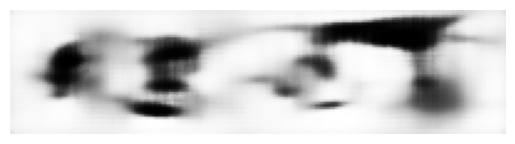

Epoch 13/150
Gen LR: 0.000086 | Disc LR: 0.000171
Generator Loss: 6.1914
Discriminator Loss: 0.3536
Time: 78.87 sec

Epoch 14


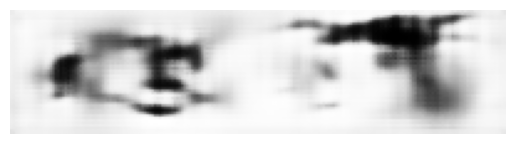

Epoch 14/150
Gen LR: 0.000086 | Disc LR: 0.000171
Generator Loss: 5.2244
Discriminator Loss: 0.3684
Time: 78.95 sec

Epoch 15


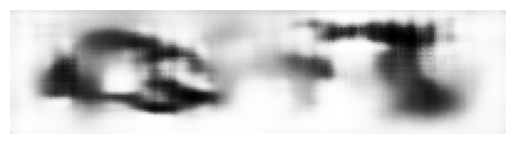

Epoch 15/150
Gen LR: 0.000081 | Disc LR: 0.000163
Generator Loss: 5.1876
Discriminator Loss: 0.3792
Time: 78.68 sec

Epoch 16


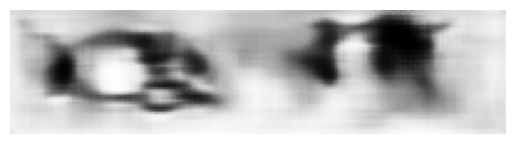

Epoch 16/150
Gen LR: 0.000081 | Disc LR: 0.000163
Generator Loss: 4.7893
Discriminator Loss: 0.3887
Time: 78.87 sec
✅ Best generator model saved.

Epoch 17


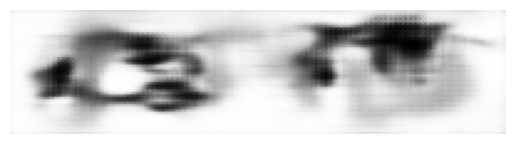

Epoch 17/150
Gen LR: 0.000081 | Disc LR: 0.000163
Generator Loss: 5.1210
Discriminator Loss: 0.4010
Time: 78.92 sec

Epoch 18


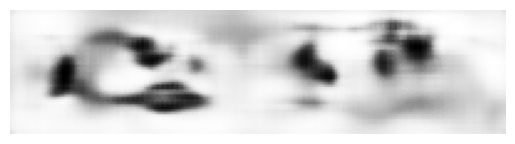

Epoch 18/150
Gen LR: 0.000077 | Disc LR: 0.000155
Generator Loss: 4.9998
Discriminator Loss: 0.3920
Time: 79.02 sec

Epoch 19


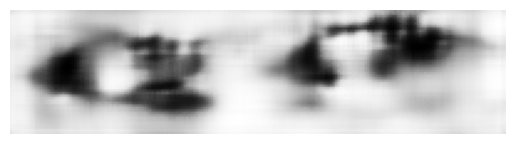

Epoch 19/150
Gen LR: 0.000077 | Disc LR: 0.000155
Generator Loss: 4.7816
Discriminator Loss: 0.4043
Time: 78.97 sec
✅ Best generator model saved.

Epoch 20


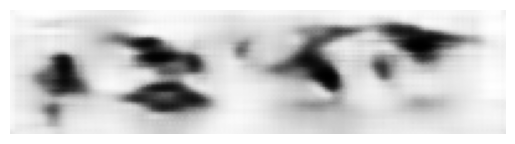

Epoch 20/150
Gen LR: 0.000077 | Disc LR: 0.000155
Generator Loss: 4.9204
Discriminator Loss: 0.3983
Time: 79.02 sec

Epoch 21


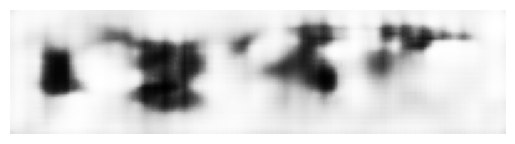

Epoch 21/150
Gen LR: 0.000077 | Disc LR: 0.000155
Generator Loss: 4.4384
Discriminator Loss: 0.4032
Time: 78.97 sec
✅ Best generator model saved.

Epoch 22


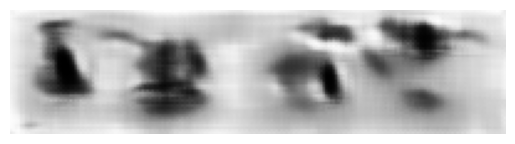

Epoch 22/150
Gen LR: 0.000074 | Disc LR: 0.000147
Generator Loss: 4.6009
Discriminator Loss: 0.4203
Time: 79.01 sec

Epoch 23


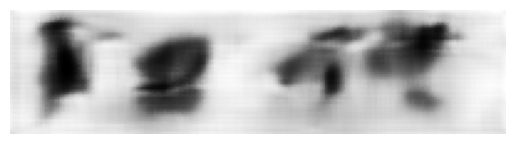

Epoch 23/150
Gen LR: 0.000074 | Disc LR: 0.000147
Generator Loss: 3.8717
Discriminator Loss: 0.4249
Time: 78.84 sec
✅ Best generator model saved.

Epoch 24


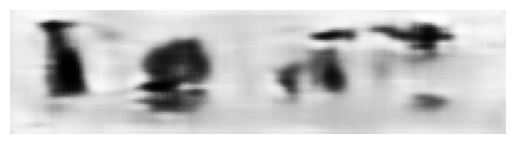

Epoch 24/150
Gen LR: 0.000074 | Disc LR: 0.000147
Generator Loss: 4.0347
Discriminator Loss: 0.4315
Time: 78.97 sec

Epoch 25


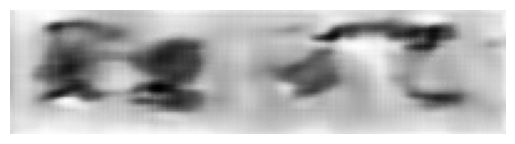

Epoch 25/150
Gen LR: 0.000070 | Disc LR: 0.000140
Generator Loss: 3.8577
Discriminator Loss: 0.4334
Time: 79.12 sec
✅ Best generator model saved.

Epoch 26


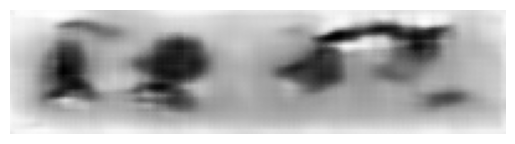

Epoch 26/150
Gen LR: 0.000070 | Disc LR: 0.000140
Generator Loss: 3.6361
Discriminator Loss: 0.4276
Time: 79.02 sec
✅ Best generator model saved.

Epoch 27


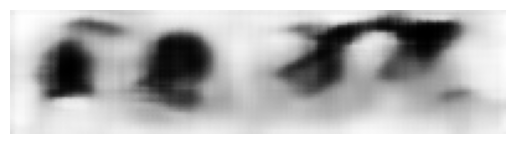

Epoch 27/150
Gen LR: 0.000070 | Disc LR: 0.000140
Generator Loss: 3.6172
Discriminator Loss: 0.4330
Time: 78.92 sec
✅ Best generator model saved.

Epoch 28


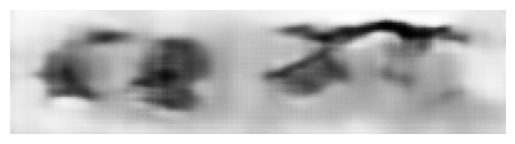

Epoch 28/150
Gen LR: 0.000070 | Disc LR: 0.000140
Generator Loss: 3.5437
Discriminator Loss: 0.4318
Time: 78.82 sec
✅ Best generator model saved.

Epoch 29


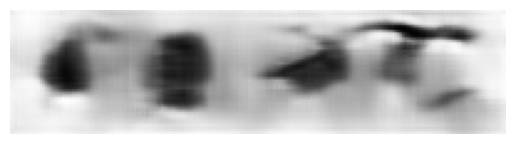

Epoch 29/150
Gen LR: 0.000066 | Disc LR: 0.000133
Generator Loss: 3.4702
Discriminator Loss: 0.4433
Time: 78.86 sec
✅ Best generator model saved.

Epoch 30


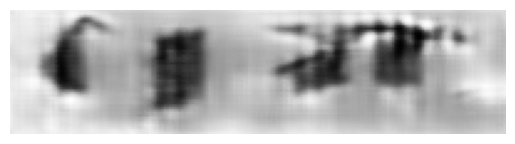

Epoch 30/150
Gen LR: 0.000066 | Disc LR: 0.000133
Generator Loss: 3.0232
Discriminator Loss: 0.4378
Time: 78.79 sec
✅ Best generator model saved.

Epoch 31


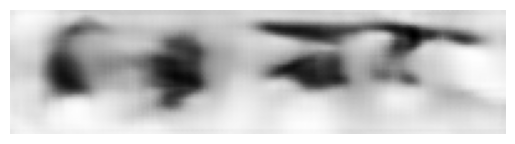

Epoch 31/150
Gen LR: 0.000066 | Disc LR: 0.000133
Generator Loss: 3.1548
Discriminator Loss: 0.4417
Time: 78.74 sec

Epoch 32


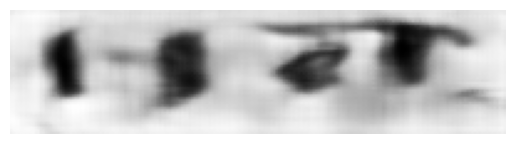

Epoch 32/150
Gen LR: 0.000063 | Disc LR: 0.000126
Generator Loss: 3.2345
Discriminator Loss: 0.4457
Time: 78.93 sec

Epoch 33


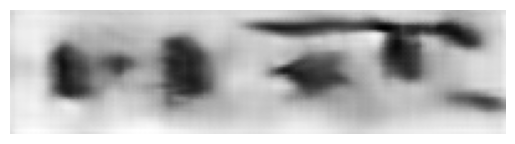

Epoch 33/150
Gen LR: 0.000063 | Disc LR: 0.000126
Generator Loss: 3.3149
Discriminator Loss: 0.4558
Time: 79.12 sec

Epoch 34


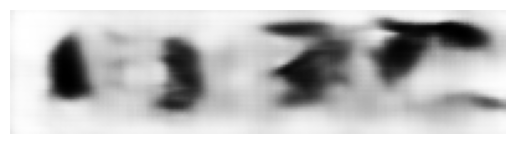

Epoch 34/150
Gen LR: 0.000063 | Disc LR: 0.000126
Generator Loss: 3.3247
Discriminator Loss: 0.4455
Time: 79.09 sec

Epoch 35


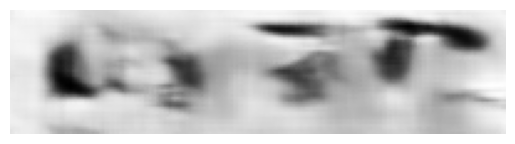

Epoch 35/150
Gen LR: 0.000063 | Disc LR: 0.000126
Generator Loss: 3.1823
Discriminator Loss: 0.4447
Time: 79.07 sec

Epoch 36


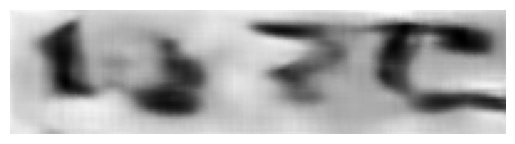

Epoch 36/150
Gen LR: 0.000060 | Disc LR: 0.000120
Generator Loss: 3.0772
Discriminator Loss: 0.4444
Time: 78.84 sec

Epoch 37


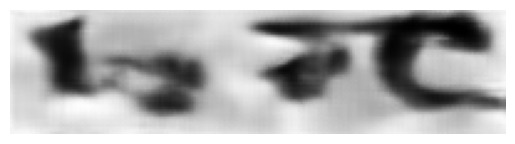

Epoch 37/150
Gen LR: 0.000060 | Disc LR: 0.000120
Generator Loss: 2.9460
Discriminator Loss: 0.4455
Time: 79.00 sec
✅ Best generator model saved.

Epoch 38


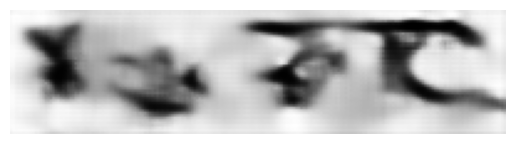

Epoch 38/150
Gen LR: 0.000060 | Disc LR: 0.000120
Generator Loss: 4.0263
Discriminator Loss: 0.4382
Time: 78.92 sec

Epoch 39


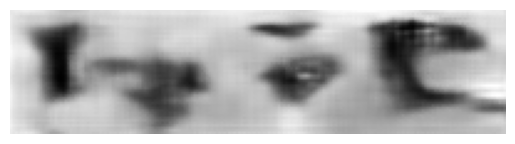

Epoch 39/150
Gen LR: 0.000060 | Disc LR: 0.000120
Generator Loss: 3.1280
Discriminator Loss: 0.4416
Time: 79.02 sec

Epoch 40


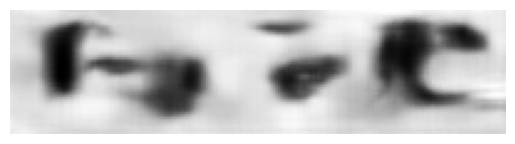

Epoch 40/150
Gen LR: 0.000057 | Disc LR: 0.000114
Generator Loss: 2.9463
Discriminator Loss: 0.4412
Time: 78.79 sec

Epoch 41


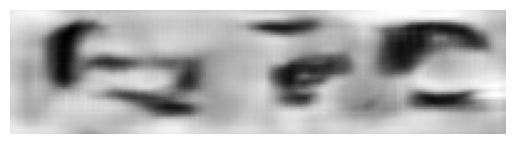

Epoch 41/150
Gen LR: 0.000057 | Disc LR: 0.000114
Generator Loss: 3.0249
Discriminator Loss: 0.4457
Time: 79.21 sec

Epoch 42


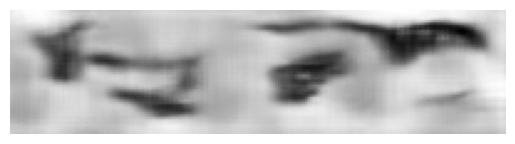

Epoch 42/150
Gen LR: 0.000057 | Disc LR: 0.000114
Generator Loss: 3.1141
Discriminator Loss: 0.4429
Time: 79.22 sec

Epoch 43


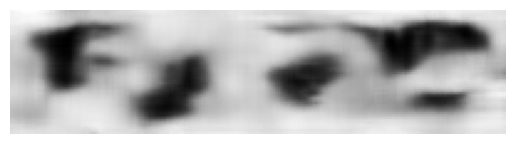

Epoch 43/150
Gen LR: 0.000054 | Disc LR: 0.000108
Generator Loss: 3.1128
Discriminator Loss: 0.4388
Time: 79.06 sec

Epoch 44


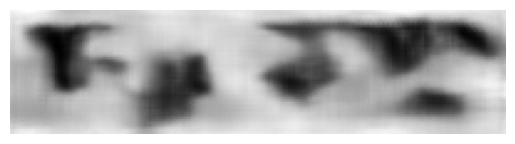

Epoch 44/150
Gen LR: 0.000054 | Disc LR: 0.000108
Generator Loss: 3.0970
Discriminator Loss: 0.4465
Time: 78.78 sec

Epoch 45


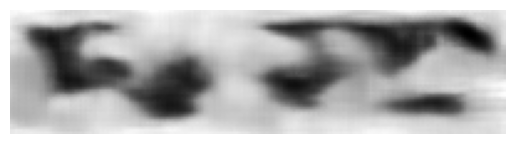

Epoch 45/150
Gen LR: 0.000054 | Disc LR: 0.000108
Generator Loss: 3.0995
Discriminator Loss: 0.4460
Time: 78.99 sec

Epoch 46


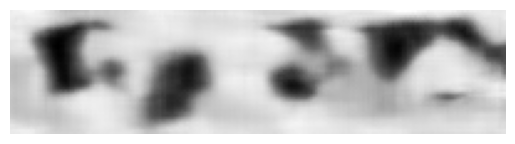

Epoch 46/150
Gen LR: 0.000054 | Disc LR: 0.000108
Generator Loss: 2.9717
Discriminator Loss: 0.4416
Time: 79.07 sec

Epoch 47


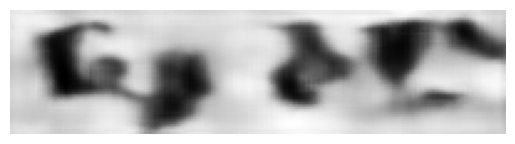

Epoch 47/150
Gen LR: 0.000051 | Disc LR: 0.000103
Generator Loss: 3.0300
Discriminator Loss: 0.4419
Time: 78.88 sec

Epoch 48


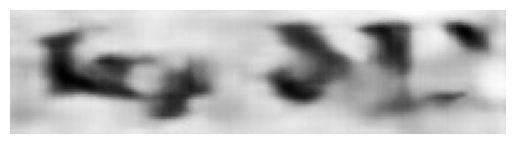

Epoch 48/150
Gen LR: 0.000051 | Disc LR: 0.000103
Generator Loss: 3.0895
Discriminator Loss: 0.4456
Time: 79.09 sec

Epoch 49


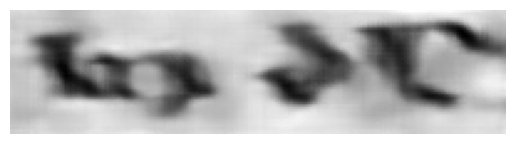

Epoch 49/150
Gen LR: 0.000051 | Disc LR: 0.000103
Generator Loss: 3.0690
Discriminator Loss: 0.4488
Time: 78.87 sec

Epoch 50


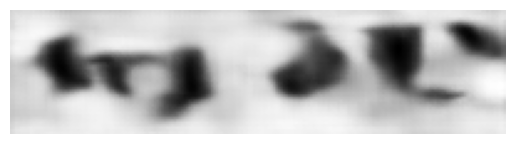

Epoch 50/150
Gen LR: 0.000049 | Disc LR: 0.000098
Generator Loss: 2.9278
Discriminator Loss: 0.4448
Time: 78.99 sec
✅ Best generator model saved.

Epoch 51


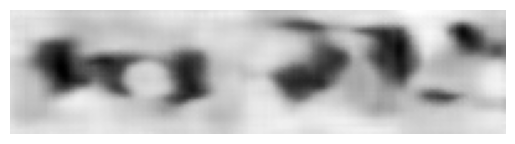

Epoch 51/150
Gen LR: 0.000049 | Disc LR: 0.000098
Generator Loss: 3.1033
Discriminator Loss: 0.4463
Time: 78.83 sec

Epoch 52


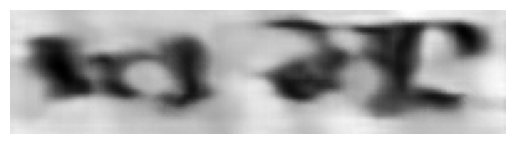

Epoch 52/150
Gen LR: 0.000049 | Disc LR: 0.000098
Generator Loss: 2.9439
Discriminator Loss: 0.4429
Time: 78.93 sec

Epoch 53


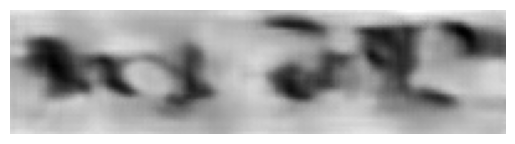

Epoch 53/150
Gen LR: 0.000049 | Disc LR: 0.000098
Generator Loss: 2.9105
Discriminator Loss: 0.4465
Time: 79.10 sec
✅ Best generator model saved.

Epoch 54


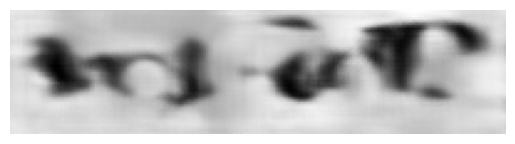

Epoch 54/150
Gen LR: 0.000046 | Disc LR: 0.000093
Generator Loss: 2.9031
Discriminator Loss: 0.4461
Time: 78.81 sec
✅ Best generator model saved.

Epoch 55


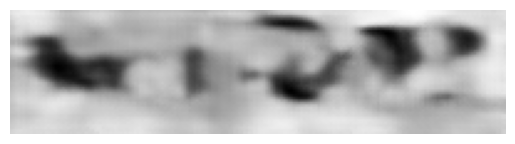

Epoch 55/150
Gen LR: 0.000046 | Disc LR: 0.000093
Generator Loss: 2.9079
Discriminator Loss: 0.4448
Time: 79.04 sec

Epoch 56


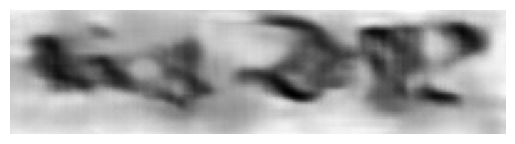

Epoch 56/150
Gen LR: 0.000046 | Disc LR: 0.000093
Generator Loss: 2.9071
Discriminator Loss: 0.4551
Time: 79.04 sec

Epoch 57


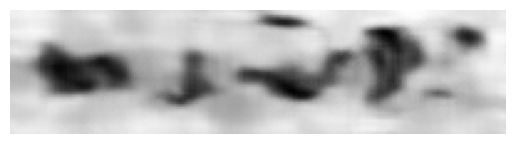

Epoch 57/150
Gen LR: 0.000044 | Disc LR: 0.000088
Generator Loss: 2.9872
Discriminator Loss: 0.4457
Time: 79.00 sec

Epoch 58


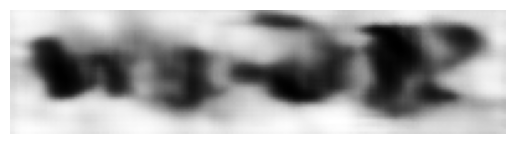

Epoch 58/150
Gen LR: 0.000044 | Disc LR: 0.000088
Generator Loss: 3.0705
Discriminator Loss: 0.4470
Time: 79.13 sec

Epoch 59


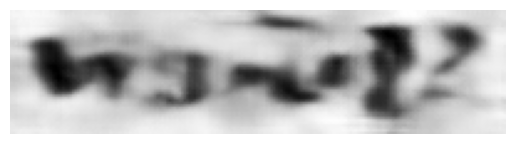

Epoch 59/150
Gen LR: 0.000044 | Disc LR: 0.000088
Generator Loss: 3.0908
Discriminator Loss: 0.4452
Time: 79.00 sec

Epoch 60


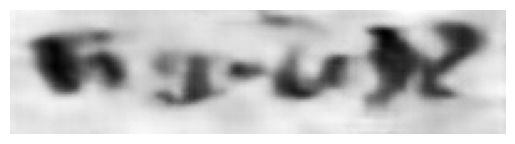

Epoch 60/150
Gen LR: 0.000044 | Disc LR: 0.000088
Generator Loss: 2.8074
Discriminator Loss: 0.4475
Time: 78.79 sec
✅ Best generator model saved.

Epoch 61


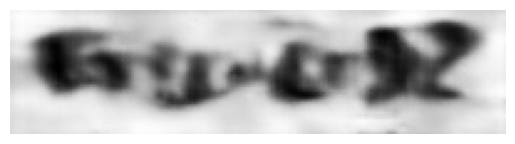

Epoch 61/150
Gen LR: 0.000042 | Disc LR: 0.000084
Generator Loss: 2.8663
Discriminator Loss: 0.4419
Time: 78.79 sec

Epoch 62


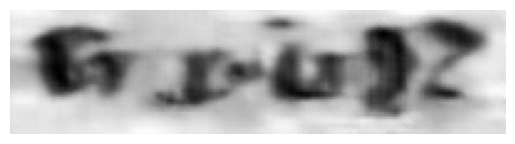

Epoch 62/150
Gen LR: 0.000042 | Disc LR: 0.000084
Generator Loss: 2.9405
Discriminator Loss: 0.4468
Time: 78.81 sec

Epoch 63


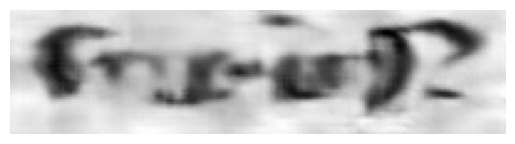

Epoch 63/150
Gen LR: 0.000042 | Disc LR: 0.000084
Generator Loss: 2.8355
Discriminator Loss: 0.4446
Time: 78.94 sec

Epoch 64


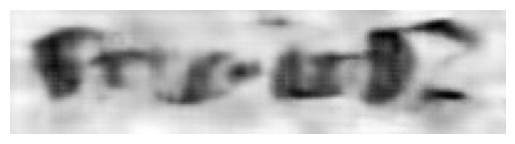

Epoch 64/150
Gen LR: 0.000040 | Disc LR: 0.000079
Generator Loss: 2.9637
Discriminator Loss: 0.4480
Time: 78.92 sec

Epoch 65


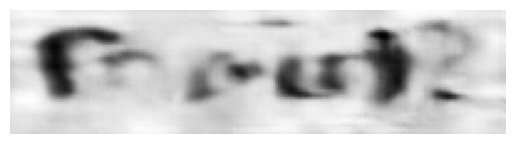

Epoch 65/150
Gen LR: 0.000040 | Disc LR: 0.000079
Generator Loss: 2.8451
Discriminator Loss: 0.4442
Time: 79.10 sec

Epoch 66


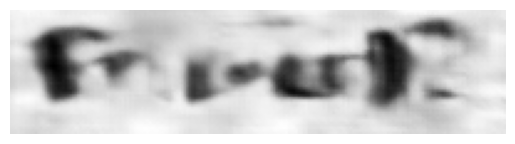

Epoch 66/150
Gen LR: 0.000040 | Disc LR: 0.000079
Generator Loss: 2.8296
Discriminator Loss: 0.4459
Time: 78.94 sec

Epoch 67


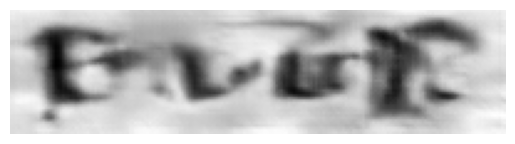

Epoch 67/150
Gen LR: 0.000040 | Disc LR: 0.000079
Generator Loss: 2.7622
Discriminator Loss: 0.4462
Time: 78.94 sec
✅ Best generator model saved.

Epoch 68


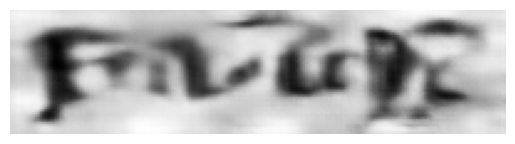

Epoch 68/150
Gen LR: 0.000038 | Disc LR: 0.000075
Generator Loss: 2.9317
Discriminator Loss: 0.4497
Time: 78.95 sec

Epoch 69


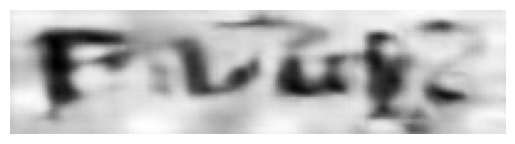

Epoch 69/150
Gen LR: 0.000038 | Disc LR: 0.000075
Generator Loss: 2.7567
Discriminator Loss: 0.4480
Time: 79.17 sec
✅ Best generator model saved.

Epoch 70


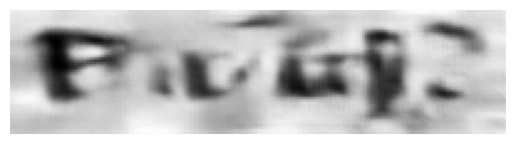

Epoch 70/150
Gen LR: 0.000038 | Disc LR: 0.000075
Generator Loss: 2.7691
Discriminator Loss: 0.4482
Time: 78.85 sec

Epoch 71


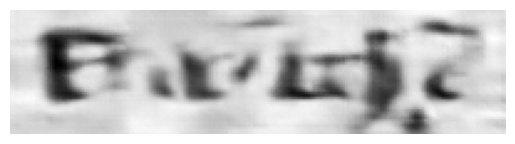

Epoch 71/150
Gen LR: 0.000036 | Disc LR: 0.000072
Generator Loss: 2.7276
Discriminator Loss: 0.4495
Time: 79.11 sec
✅ Best generator model saved.

Epoch 72


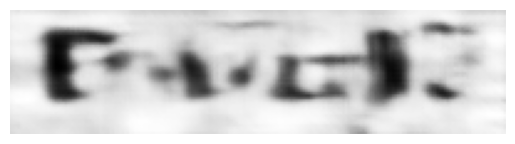

Epoch 72/150
Gen LR: 0.000036 | Disc LR: 0.000072
Generator Loss: 2.8715
Discriminator Loss: 0.4494
Time: 79.04 sec

Epoch 73


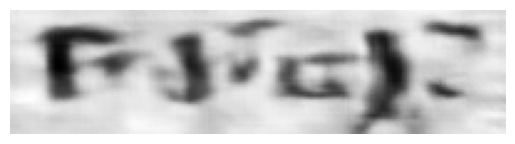

Epoch 73/150
Gen LR: 0.000036 | Disc LR: 0.000072
Generator Loss: 2.8205
Discriminator Loss: 0.4501
Time: 78.96 sec

Epoch 74


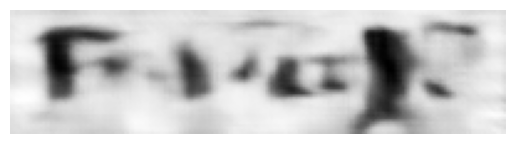

Epoch 74/150
Gen LR: 0.000036 | Disc LR: 0.000072
Generator Loss: 2.9161
Discriminator Loss: 0.4451
Time: 78.82 sec

Epoch 75


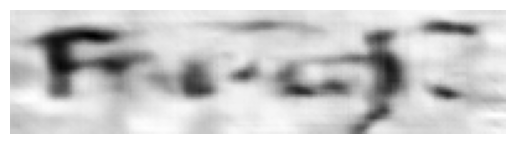

Epoch 75/150
Gen LR: 0.000034 | Disc LR: 0.000068
Generator Loss: 2.8935
Discriminator Loss: 0.4467
Time: 79.13 sec

Epoch 76


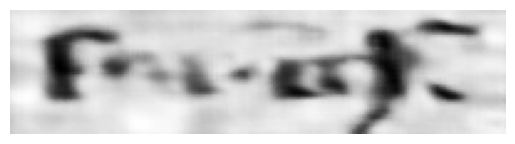

Epoch 76/150
Gen LR: 0.000034 | Disc LR: 0.000068
Generator Loss: 3.0435
Discriminator Loss: 0.4469
Time: 78.83 sec

Epoch 77


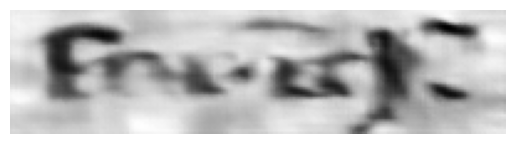

Epoch 77/150
Gen LR: 0.000034 | Disc LR: 0.000068
Generator Loss: 2.8437
Discriminator Loss: 0.4500
Time: 79.09 sec

Epoch 78


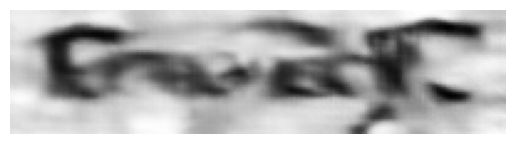

Epoch 78/150
Gen LR: 0.000034 | Disc LR: 0.000068
Generator Loss: 2.8389
Discriminator Loss: 0.4465
Time: 79.15 sec

Epoch 79


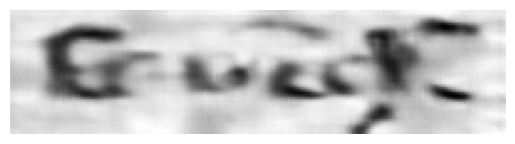

Epoch 79/150
Gen LR: 0.000032 | Disc LR: 0.000065
Generator Loss: 2.7755
Discriminator Loss: 0.4461
Time: 79.03 sec

Epoch 80


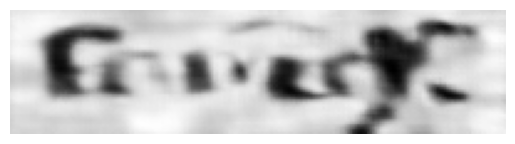

Epoch 80/150
Gen LR: 0.000032 | Disc LR: 0.000065
Generator Loss: 2.8078
Discriminator Loss: 0.4486
Time: 79.05 sec

Epoch 81


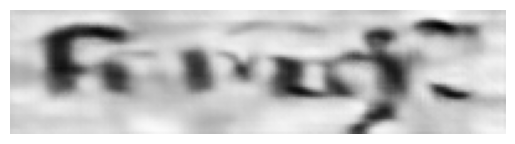

Epoch 81/150
Gen LR: 0.000032 | Disc LR: 0.000065
Generator Loss: 2.8396
Discriminator Loss: 0.4441
Time: 79.00 sec

Epoch 82


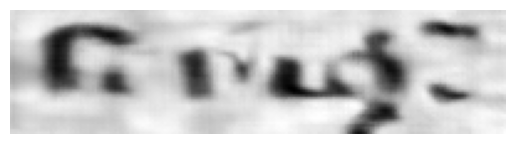

Epoch 82/150
Gen LR: 0.000031 | Disc LR: 0.000061
Generator Loss: 2.8757
Discriminator Loss: 0.4480
Time: 79.00 sec

Epoch 83


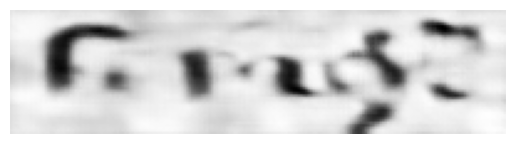

Epoch 83/150
Gen LR: 0.000031 | Disc LR: 0.000061
Generator Loss: 2.8437
Discriminator Loss: 0.4483
Time: 79.01 sec

Epoch 84


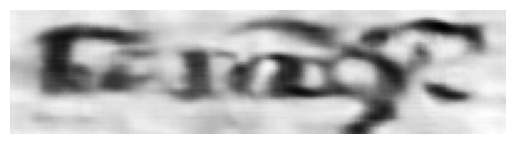

Epoch 84/150
Gen LR: 0.000031 | Disc LR: 0.000061
Generator Loss: 2.9556
Discriminator Loss: 0.4478
Time: 79.07 sec

Epoch 85


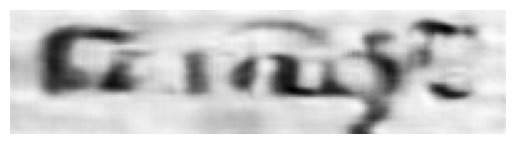

Epoch 85/150
Gen LR: 0.000031 | Disc LR: 0.000061
Generator Loss: 2.8155
Discriminator Loss: 0.4477
Time: 79.10 sec

Epoch 86


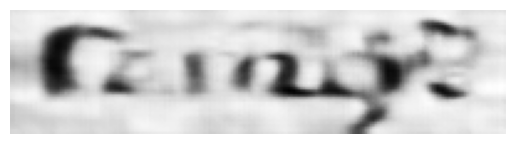

Epoch 86/150
Gen LR: 0.000029 | Disc LR: 0.000058
Generator Loss: 2.7960
Discriminator Loss: 0.4461
Time: 79.09 sec

Epoch 87


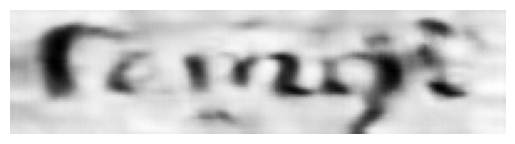

Epoch 87/150
Gen LR: 0.000029 | Disc LR: 0.000058
Generator Loss: 2.9053
Discriminator Loss: 0.4483
Time: 79.02 sec

Epoch 88


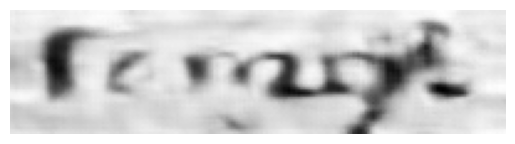

Epoch 88/150
Gen LR: 0.000029 | Disc LR: 0.000058
Generator Loss: 2.9127
Discriminator Loss: 0.4428
Time: 79.07 sec

Epoch 89


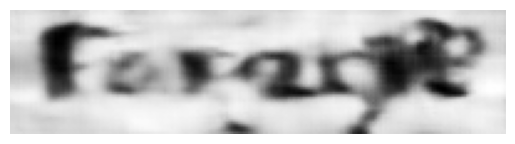

Epoch 89/150
Gen LR: 0.000028 | Disc LR: 0.000055
Generator Loss: 2.8921
Discriminator Loss: 0.4434
Time: 79.02 sec

Epoch 90


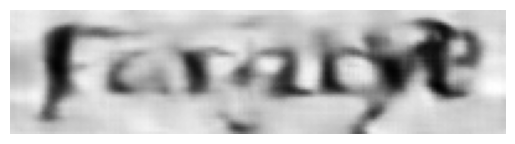

Epoch 90/150
Gen LR: 0.000028 | Disc LR: 0.000055
Generator Loss: 2.9023
Discriminator Loss: 0.4452
Time: 78.98 sec

Epoch 91


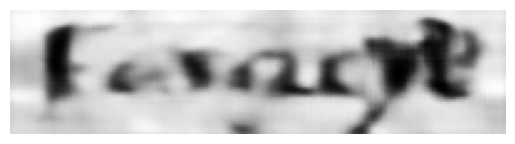

Epoch 91/150
Gen LR: 0.000028 | Disc LR: 0.000055
Generator Loss: 3.1807
Discriminator Loss: 0.4470
Time: 78.97 sec

Epoch 92


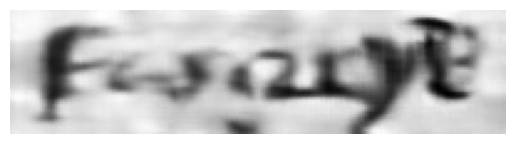

Epoch 92/150
Gen LR: 0.000028 | Disc LR: 0.000055
Generator Loss: 2.9801
Discriminator Loss: 0.4439
Time: 78.94 sec

Epoch 93


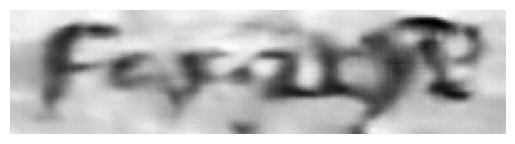

Epoch 93/150
Gen LR: 0.000026 | Disc LR: 0.000053
Generator Loss: 2.9113
Discriminator Loss: 0.4421
Time: 78.98 sec

Epoch 94


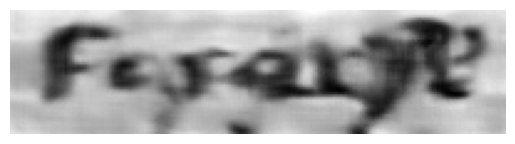

Epoch 94/150
Gen LR: 0.000026 | Disc LR: 0.000053
Generator Loss: 2.9007
Discriminator Loss: 0.4426
Time: 79.06 sec

Epoch 95


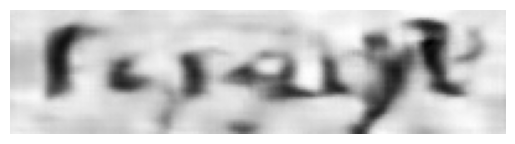

Epoch 95/150
Gen LR: 0.000026 | Disc LR: 0.000053
Generator Loss: 2.9213
Discriminator Loss: 0.4390
Time: 79.17 sec

Epoch 96


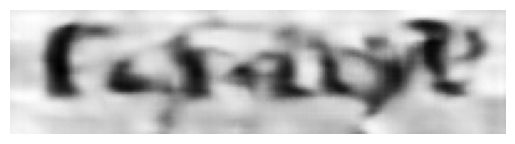

Epoch 96/150
Gen LR: 0.000025 | Disc LR: 0.000050
Generator Loss: 3.0532
Discriminator Loss: 0.4395
Time: 79.02 sec

Epoch 97


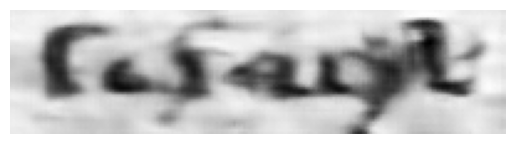

Epoch 97/150
Gen LR: 0.000025 | Disc LR: 0.000050
Generator Loss: 2.8738
Discriminator Loss: 0.4403
Time: 78.90 sec

Epoch 98


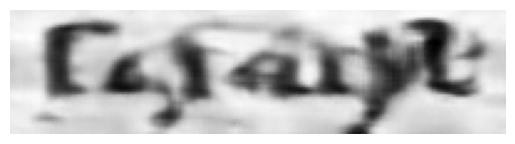

Epoch 98/150
Gen LR: 0.000025 | Disc LR: 0.000050
Generator Loss: 2.8751
Discriminator Loss: 0.4401
Time: 78.80 sec

Epoch 99


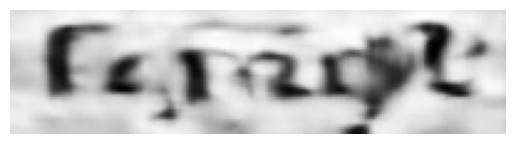

Epoch 99/150
Gen LR: 0.000025 | Disc LR: 0.000050
Generator Loss: 3.0323
Discriminator Loss: 0.4410
Time: 78.71 sec

Epoch 100


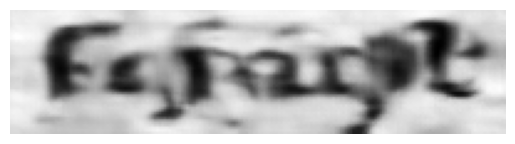

Epoch 100/150
Gen LR: 0.000024 | Disc LR: 0.000048
Generator Loss: 2.9608
Discriminator Loss: 0.4368
Time: 78.77 sec

Epoch 101


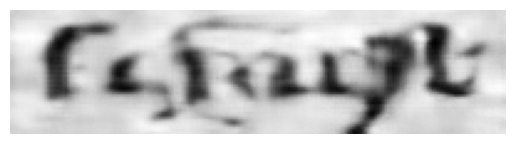

Epoch 101/150
Gen LR: 0.000024 | Disc LR: 0.000048
Generator Loss: 2.9960
Discriminator Loss: 0.4404
Time: 78.60 sec

Epoch 102


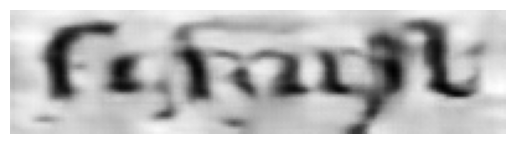

Epoch 102/150
Gen LR: 0.000024 | Disc LR: 0.000048
Generator Loss: 2.9612
Discriminator Loss: 0.4374
Time: 79.03 sec

Epoch 103


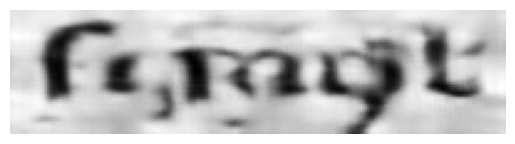

Epoch 103/150
Gen LR: 0.000023 | Disc LR: 0.000045
Generator Loss: 2.9503
Discriminator Loss: 0.4410
Time: 78.98 sec

Epoch 104


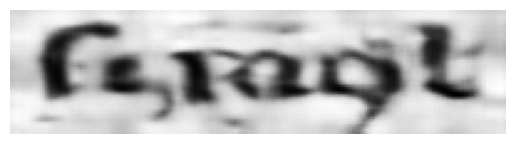

Epoch 104/150
Gen LR: 0.000023 | Disc LR: 0.000045
Generator Loss: 2.9836
Discriminator Loss: 0.4390
Time: 79.09 sec

Epoch 105


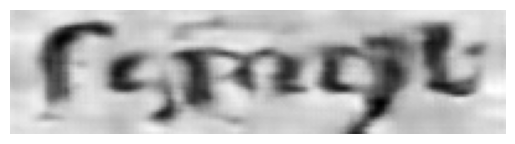

Epoch 105/150
Gen LR: 0.000023 | Disc LR: 0.000045
Generator Loss: 3.0163
Discriminator Loss: 0.4373
Time: 78.84 sec

Epoch 106


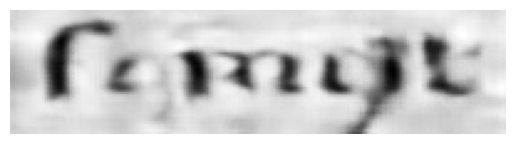

Epoch 106/150
Gen LR: 0.000023 | Disc LR: 0.000045
Generator Loss: 3.0544
Discriminator Loss: 0.4383
Time: 79.17 sec

Epoch 107


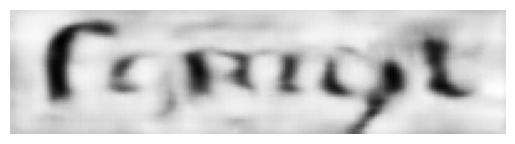

Epoch 107/150
Gen LR: 0.000021 | Disc LR: 0.000043
Generator Loss: 3.1469
Discriminator Loss: 0.4336
Time: 78.86 sec

Epoch 108


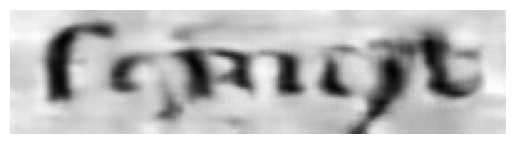

Epoch 108/150
Gen LR: 0.000021 | Disc LR: 0.000043
Generator Loss: 3.0788
Discriminator Loss: 0.4343
Time: 78.89 sec

Epoch 109


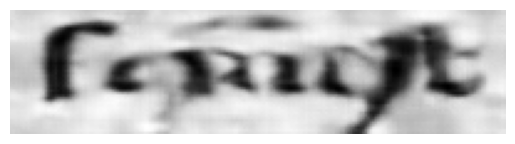

Epoch 109/150
Gen LR: 0.000021 | Disc LR: 0.000043
Generator Loss: 3.0321
Discriminator Loss: 0.4369
Time: 78.78 sec

Epoch 110


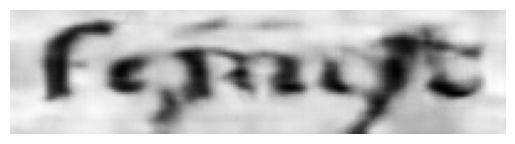

Epoch 110/150
Gen LR: 0.000020 | Disc LR: 0.000041
Generator Loss: 3.0223
Discriminator Loss: 0.4364
Time: 78.96 sec

Epoch 111


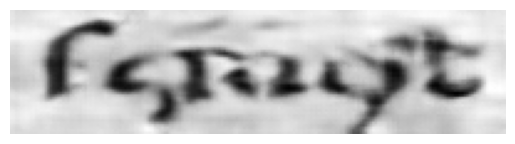

Epoch 111/150
Gen LR: 0.000020 | Disc LR: 0.000041
Generator Loss: 2.9424
Discriminator Loss: 0.4358
Time: 78.92 sec

Epoch 112


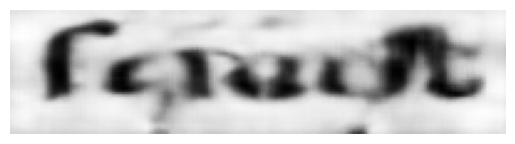

Epoch 112/150
Gen LR: 0.000020 | Disc LR: 0.000041
Generator Loss: 3.0325
Discriminator Loss: 0.4333
Time: 78.84 sec

Epoch 113


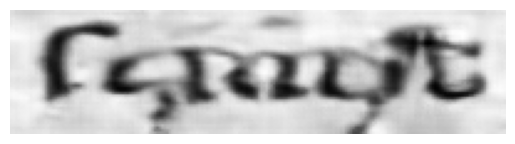

Epoch 113/150
Gen LR: 0.000020 | Disc LR: 0.000041
Generator Loss: 3.0980
Discriminator Loss: 0.4312
Time: 79.08 sec

Epoch 114


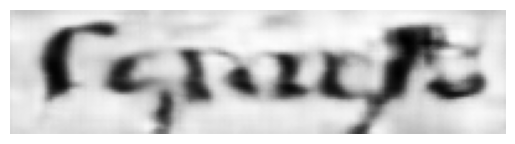

Epoch 114/150
Gen LR: 0.000019 | Disc LR: 0.000039
Generator Loss: 3.1187
Discriminator Loss: 0.4332
Time: 78.74 sec

Epoch 115


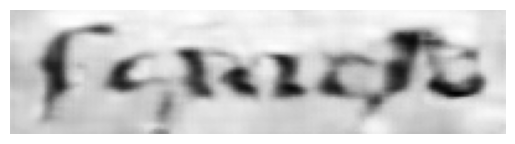

Epoch 115/150
Gen LR: 0.000019 | Disc LR: 0.000039
Generator Loss: 3.1419
Discriminator Loss: 0.4323
Time: 78.96 sec

Epoch 116


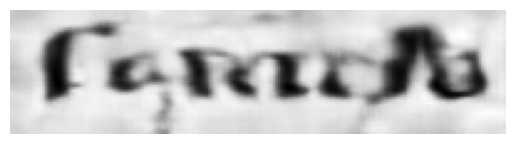

Epoch 116/150
Gen LR: 0.000019 | Disc LR: 0.000039
Generator Loss: 3.0990
Discriminator Loss: 0.4322
Time: 79.06 sec

Epoch 117


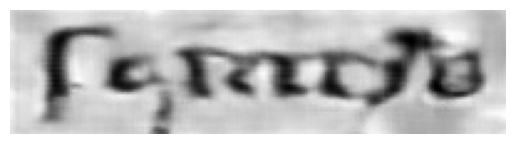

Epoch 117/150
Gen LR: 0.000019 | Disc LR: 0.000039
Generator Loss: 3.1925
Discriminator Loss: 0.4297
Time: 79.08 sec

Epoch 118


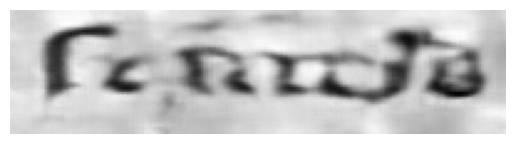

Epoch 118/150
Gen LR: 0.000018 | Disc LR: 0.000037
Generator Loss: 3.1930
Discriminator Loss: 0.4320
Time: 79.03 sec

Epoch 119


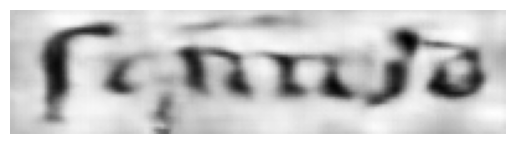

Epoch 119/150
Gen LR: 0.000018 | Disc LR: 0.000037
Generator Loss: 3.1335
Discriminator Loss: 0.4288
Time: 79.22 sec

Epoch 120


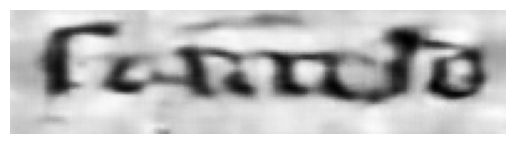

Epoch 120/150
Gen LR: 0.000018 | Disc LR: 0.000037
Generator Loss: 3.1397
Discriminator Loss: 0.4280
Time: 79.10 sec

Epoch 121


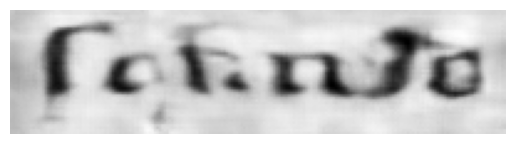

Epoch 121/150
Gen LR: 0.000017 | Disc LR: 0.000035
Generator Loss: 3.0811
Discriminator Loss: 0.4280
Time: 78.99 sec

Epoch 122


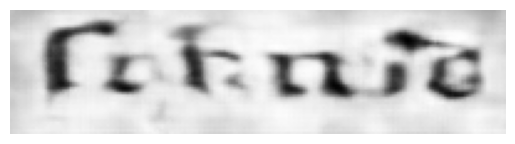

Epoch 122/150
Gen LR: 0.000017 | Disc LR: 0.000035
Generator Loss: 3.1547
Discriminator Loss: 0.4290
Time: 78.87 sec

Epoch 123


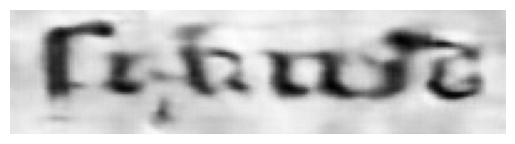

Epoch 123/150
Gen LR: 0.000017 | Disc LR: 0.000035
Generator Loss: 3.1611
Discriminator Loss: 0.4296
Time: 78.85 sec

Epoch 124


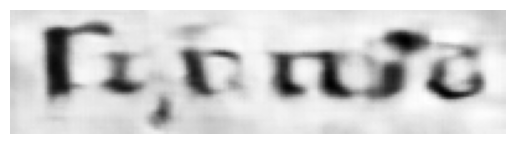

Epoch 124/150
Gen LR: 0.000017 | Disc LR: 0.000035
Generator Loss: 3.1199
Discriminator Loss: 0.4291
Time: 78.75 sec

Epoch 125


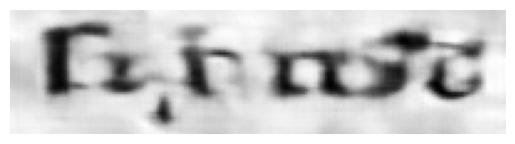

Epoch 125/150
Gen LR: 0.000017 | Disc LR: 0.000033
Generator Loss: 3.1841
Discriminator Loss: 0.4283
Time: 79.02 sec

Epoch 126


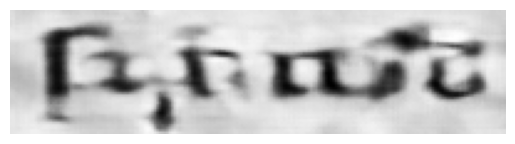

Epoch 126/150
Gen LR: 0.000017 | Disc LR: 0.000033
Generator Loss: 3.1229
Discriminator Loss: 0.4283
Time: 79.09 sec

Epoch 127


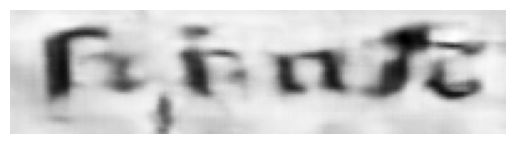

Epoch 127/150
Gen LR: 0.000017 | Disc LR: 0.000033
Generator Loss: 3.2798
Discriminator Loss: 0.4260
Time: 79.11 sec

Epoch 128


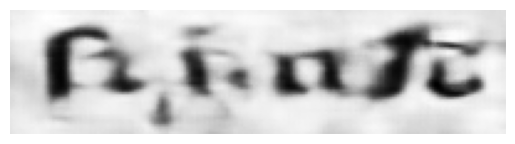

Epoch 128/150
Gen LR: 0.000016 | Disc LR: 0.000032
Generator Loss: 3.1660
Discriminator Loss: 0.4275
Time: 79.16 sec

Epoch 129


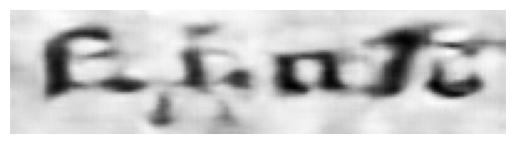

Epoch 129/150
Gen LR: 0.000016 | Disc LR: 0.000032
Generator Loss: 3.2513
Discriminator Loss: 0.4274
Time: 79.02 sec

Epoch 130


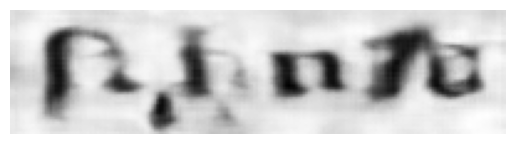

Epoch 130/150
Gen LR: 0.000016 | Disc LR: 0.000032
Generator Loss: 3.2265
Discriminator Loss: 0.4294
Time: 78.91 sec

Epoch 131


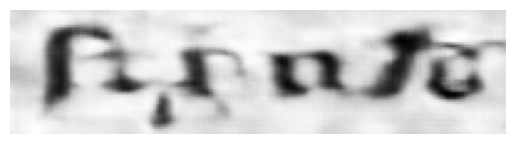

Epoch 131/150
Gen LR: 0.000016 | Disc LR: 0.000032
Generator Loss: 3.2741
Discriminator Loss: 0.4271
Time: 79.03 sec

Epoch 132


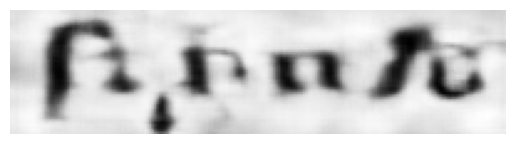

Epoch 132/150
Gen LR: 0.000015 | Disc LR: 0.000030
Generator Loss: 3.2171
Discriminator Loss: 0.4246
Time: 79.03 sec

Epoch 133


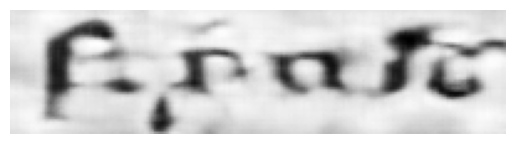

Epoch 133/150
Gen LR: 0.000015 | Disc LR: 0.000030
Generator Loss: 3.1548
Discriminator Loss: 0.4262
Time: 78.95 sec

Epoch 134


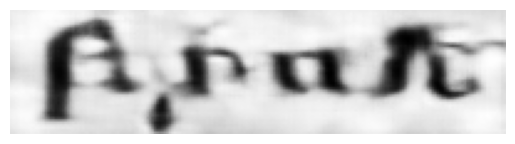

Epoch 134/150
Gen LR: 0.000015 | Disc LR: 0.000030
Generator Loss: 3.2919
Discriminator Loss: 0.4252
Time: 78.97 sec

Epoch 135


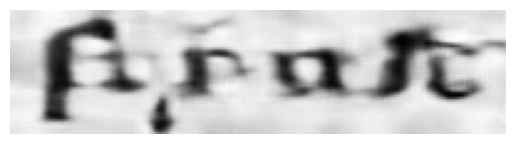

Epoch 135/150
Gen LR: 0.000014 | Disc LR: 0.000028
Generator Loss: 3.2718
Discriminator Loss: 0.4243
Time: 79.12 sec

Epoch 136


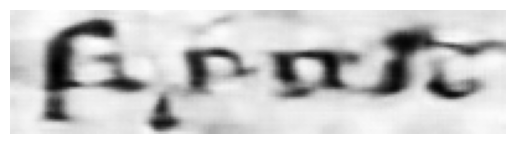

Epoch 136/150
Gen LR: 0.000014 | Disc LR: 0.000028
Generator Loss: 3.3236
Discriminator Loss: 0.4243
Time: 79.01 sec

Epoch 137


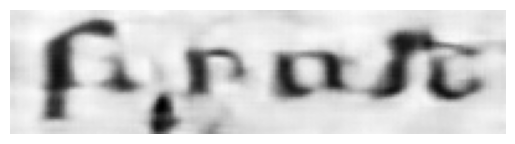

Epoch 137/150
Gen LR: 0.000014 | Disc LR: 0.000028
Generator Loss: 3.3393
Discriminator Loss: 0.4254
Time: 78.92 sec

Epoch 138


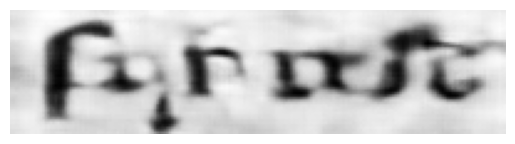

Epoch 138/150
Gen LR: 0.000014 | Disc LR: 0.000028
Generator Loss: 3.2961
Discriminator Loss: 0.4229
Time: 78.93 sec

Epoch 139


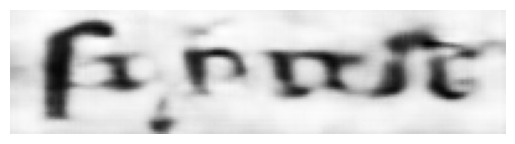

Epoch 139/150
Gen LR: 0.000014 | Disc LR: 0.000027
Generator Loss: 3.2522
Discriminator Loss: 0.4235
Time: 79.04 sec

Epoch 140


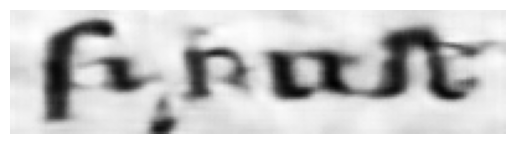

Epoch 140/150
Gen LR: 0.000014 | Disc LR: 0.000027
Generator Loss: 3.2298
Discriminator Loss: 0.4228
Time: 79.21 sec

Epoch 141


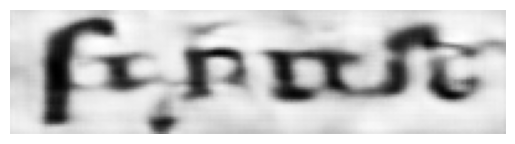

Epoch 141/150
Gen LR: 0.000014 | Disc LR: 0.000027
Generator Loss: 3.3076
Discriminator Loss: 0.4210
Time: 78.99 sec

Epoch 142


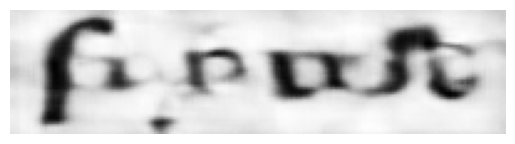

Epoch 142/150
Gen LR: 0.000013 | Disc LR: 0.000026
Generator Loss: 3.3507
Discriminator Loss: 0.4212
Time: 78.90 sec

Epoch 143


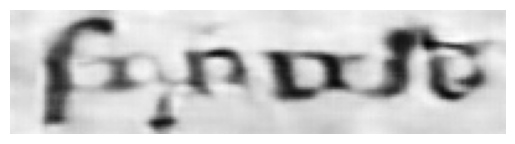

Epoch 143/150
Gen LR: 0.000013 | Disc LR: 0.000026
Generator Loss: 3.3306
Discriminator Loss: 0.4224
Time: 78.98 sec

Epoch 144


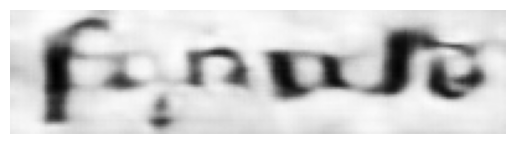

Epoch 144/150
Gen LR: 0.000013 | Disc LR: 0.000026
Generator Loss: 3.3668
Discriminator Loss: 0.4218
Time: 79.01 sec

Epoch 145


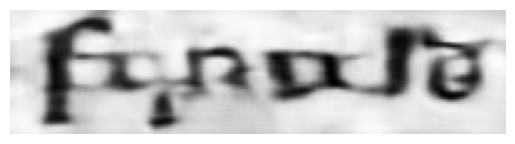

Epoch 145/150
Gen LR: 0.000013 | Disc LR: 0.000026
Generator Loss: 3.3060
Discriminator Loss: 0.4210
Time: 78.95 sec

Epoch 146


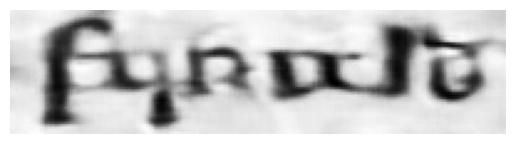

Epoch 146/150
Gen LR: 0.000012 | Disc LR: 0.000024
Generator Loss: 3.3761
Discriminator Loss: 0.4210
Time: 78.98 sec

Epoch 147


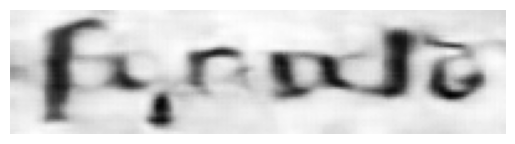

Epoch 147/150
Gen LR: 0.000012 | Disc LR: 0.000024
Generator Loss: 3.4041
Discriminator Loss: 0.4191
Time: 79.04 sec

Epoch 148


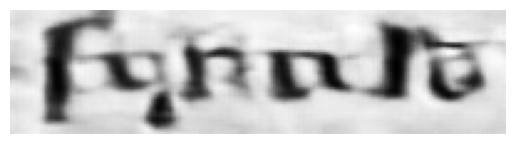

Epoch 148/150
Gen LR: 0.000012 | Disc LR: 0.000024
Generator Loss: 3.3978
Discriminator Loss: 0.4208
Time: 78.96 sec

Epoch 149


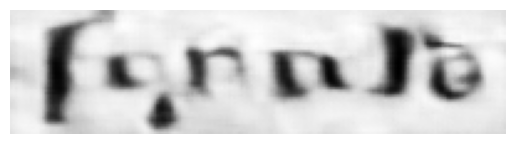

Epoch 149/150
Gen LR: 0.000012 | Disc LR: 0.000023
Generator Loss: 3.4286
Discriminator Loss: 0.4180
Time: 79.11 sec

Epoch 150


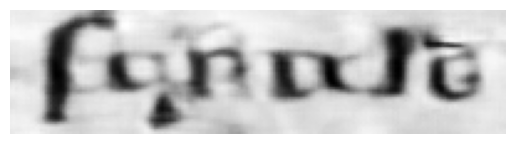

Epoch 150/150
Gen LR: 0.000012 | Disc LR: 0.000023
Generator Loss: 3.4460
Discriminator Loss: 0.4187
Time: 79.19 sec


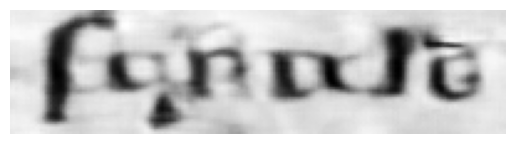

In [24]:
generator = train(train_ds, 150)

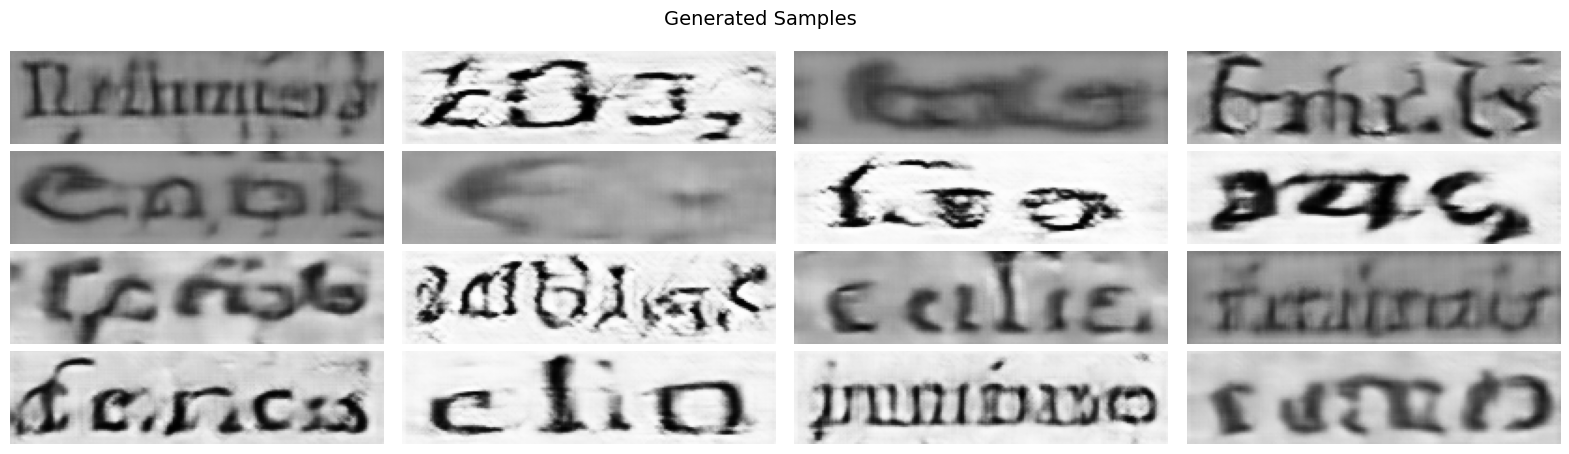

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the generator model
generator = tf.keras.models.load_model('best_generator.h5')

# Define noise dimension
noise_dim = 100

def generate_and_show_samples_grid(num_samples=16):
    noise = tf.random.normal([num_samples, noise_dim])
    generated_images = generator(noise, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(20, 5))  # Slightly smaller figure size
    fig.suptitle("Generated Samples", fontsize=14)

    for i, ax in enumerate(axes.flat):
        img = generated_images[i, :, :, 0] * 127.5 + 127.5
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.9)  # Minimize space
    plt.show()

# Display 16 images
generate_and_show_samples_grid()


### 🖼️ **Generating Text-Based Images with GAN**

This section implements a function to **generate and visualize an image** from text input using the trained **GAN model**. The process involves:
1. **Preprocessing text labels**: Converting text into a numerical format.
2. **Generating an image**: Feeding noise + text representation into the generator.
3. **Displaying the image**: Using `matplotlib` to visualize the generated image.

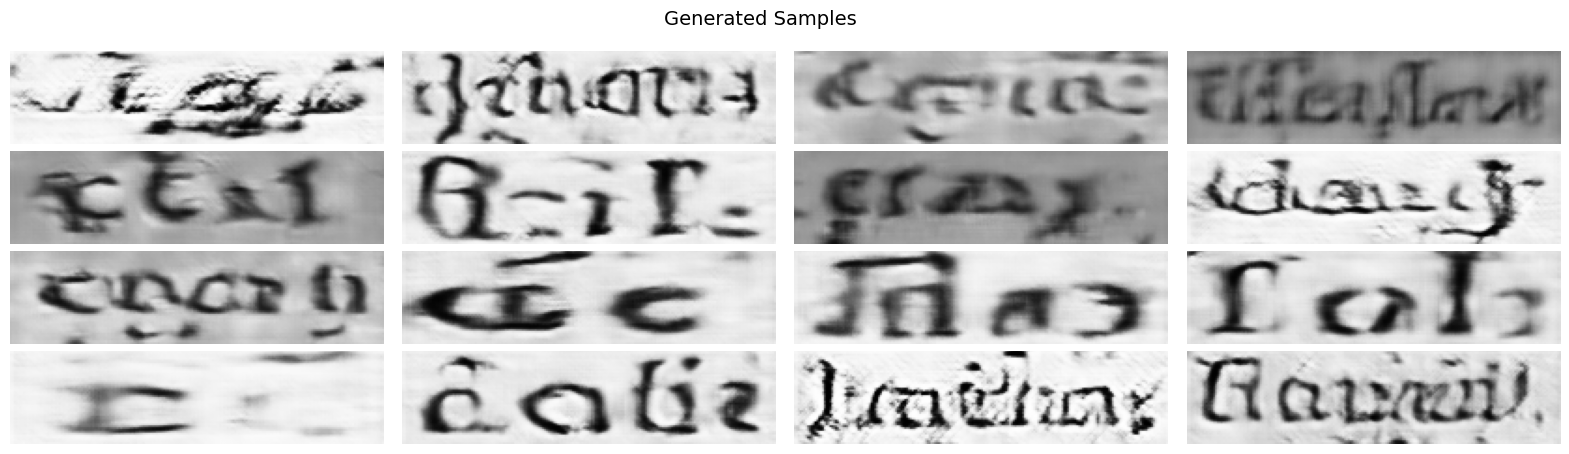

In [36]:
generate_and_show_samples_grid()

In [37]:
from google.colab import files
files.download('best_generator.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>